# P3C - A Robust Projected Clustering Algorith

### Group 6
### Robert Brunnsteiner, Mohammad Mahdi Fallah, Akshey Kumar, Manju Mariam Mathew*, Jan-Jonas Schumacher
### VU Data Mining (WS 2021/22)
*left the group

In [1]:
#imports
import numpy as np
from p3c import P3C
from elki import run_elki_P3C, run_elki_subclu, run_elki_dbscan, run_elki_kmeans
from sklearn.datasets import make_blobs
from sklearn.metrics import normalized_mutual_info_score
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

#### Task 1 (b)

<u>Overview of the Algorithm</u>

P3C is a projected clustering algorithm that aims to cluster datapoints according to a subset of attributes. It should be able to detect arbitrarily-oriented, low-dimensional projected clusters in high-dimensional spaces. It consists of the following five parts:
* Finding the projections of the true p-signatures using datapoint assignment into bins.
* Finding cluster cores using a sophisticated Apriori-like search.
* Computing projected clusters (using methods including Mahalanobis distance and Expectation Maximization).
* Outlier detection using statistical methods.
* Relevant Attributes Detection (i.e., refinement of clusters).

All those parts are thoroughly discussed below.

<u>Class design of our Implementation</u>

We implemented our algorithm by creating a calss (P3C) that works similar to the ones in scikit-learn. From the outside, a class object can be created by using the Poisson threshold as the only parameter. Then wie can fit a dataset using P3C.fit(X), predict labels using P3C.predict(X) or doing both together by calling P3C.fit_predict (X). All other methods are only used internally and start with a double underscore. After calling P3C.fit(X), cluster_centers_ contains the calculated cluster centers and after calling P3C.predict(X) labels_ contains the labels for each datapoint. All other variables are only used internally and start with a single underscore.

<u>3.1 Projections of true p-signatures</u>

We start the algorithm by computing the support set of each attribute on the normalized dataset in function compute_support(self).
Support set of an interval s is defined as below:
    
    SuppSet(S) := {x ∈ D|x.aj ∈ S}

This is possible by spliting each attribute to same number of bins with equal size.it is recommended that bin number = 1+log2(n) with n being number of data points.

Then for each attribute we look through all the data points, and assign data points to bins according to their value in said attribute.(a data point belongs to a bin if its attribute is in range of that bin)

The result is the support set of the whole data. what we need for the rest of the algorithm is support which is defined by size of each bin in support set of that attribute, which is stored in self._supports.

    Supp(S) := |SuppSet(S)|

We continue the algorithm with approximate_projection(self) in order to identify attributes with uniform distribution, and for non uniform attributes, bins with unusual high supports. From scipy.stats we use chisquare to check for uniformity in uniformity_test(self, attr)

intervals deemed uniform will be stored in and np.array with value 0, and non uniform intervals will be stored as 1.

The intervals are then assigned to self._approx_proj.

<u>3.2 Cluster Cores</u>

The challenge in this part of the algorithm is to compute the p-signatures, that represent the cluster cores. The problem lies in the fact that the number of possible p-signature combinations is high in practical applications. We approach this issue by computing the cores in a Apriori fashion and exploiting the downward closure property.  The idea is to construct an outer and inner loop for the approximate projections. The first loop represents iterations over p-signatures and the outer loop iterates through the approximate projections or 1-signatures. Then, we must check if we can create a higher dimensional p+1-
signature depending on the core conditions described in the following and taken from the original paper:

"A p-signature S = {S1, . . . ,Sp} together with its support set SuppSet(S) is called a cluster core, if:
1. For any q-signature Q ⊆ S, q = 1,p−1, and any interval S′ ∈ S \ Q, it holds that:
        Supp(Q ∪ {S′}) > ESupp (Q ∪ {S′}|Q), 
        and Poisson(Supp(Q ∪ {S′}), ESupp(Q ∪{S′}|Q)) < Poisson threshold

2. For any interval S′ not in S, it holds that 
        Supp(S ∪ {S′}) ≤ ESupp (S ∪ {S′}|S), 
        or Poisson(Supp(S ∪ {S′}), ESupp(S∪ {S′}|S) ≥ Poisson threshold."

ESupp is the expected support of the p+1 signature R=S u {S'}|S and can be computed by Supp(S) * width(S'), where the width is the length of the interval. 
The Poisson probability is used to quantify how likely Supp(R) is with respect to ESupp(R). More precisely, a less likely Supp(R) the higher the probability that S' represents the same projected cluster as S.  

In our function \__apriori_cores(self, _approx_proj_sig) the first if statement checks if the p-signature and the chosen 1-signature do not share the same dimension, avoids double counting by ignoring previously considered signatures and constructs the p+1-signature by merging the p-signature and a 1-signature with the function self.__merge(p_sig, one_sig).

The second if statement checks the first part of the above described core condition by utilizing the function self.__check_core_condition(self, p-signature, pplus1_signature).


The next section of the algorithm finds only the unique cluster cores since the above might return the same core multiple times. Finally, we implemented the second part of the core conditions, which states that the cluster cores should be maximal. This is achieved by pruning cluster cores that are subsets of higher dimensional cluster cores. Th maximal cluster cores can be accessed by the instance variable 'self.cluster_centers_'.


<u>3.3 Computing projected clusters</u>

In this part using cluster cores and their support sets (which have been computed in part 3.2), we create a matrix to store which point belongs to which cluster core, this matrix has the following shape : n (number of data points) * k (number of clusters).

The function is implemented in compute_fuzzy_membership_matrix(self). We start by assignment of fuzzy_membership_matrix to a np.array of zeros of size n*k.

For each data point we check to wich cluster it belongs and we set that to 1. Later we change 1s of each row to fraction of clusters that have this data point, by summing each row and dividing rows by k (number of clusters).

Then for rows that only contain zeros (meaning they still don't belong to a cluster) we calculate the mahalonobis distanse to all clusters and set them to the shortest on the fuzzy membership matrix.

Next using GaussianMixture from sklearn.mixture on fuzzy matrix we assign each point to the cluster that has the most probability to be a part of and we store them on self.labels_

<u>3.4 Outlier Detection</u>

In the previous computations, each point has been assigned to a projected cluster. However, the data might contain outliers that we need to detect. Here, we tried to use a multivariate outlier detection. For each cluster core and each assigned instance, we compute the inverse of the covariance matrix, as well as the cluster mean. More precisely, this information can be used to compute the mahalanobis distance for each point to the mean in the respective cluster core. This distance measure finds outliers depending on the distribution pattern of data points. In order to detect outliers, we need a threshold or critical value. The cutoff value is computed by the Chi-square distribution, where the degrees of freedom is equivalent to the number of features and a confidence level of alpha = 0.001. The confidence level specifies the probability of failing to identify a outlier is less than alpha. 

In the next cell, we draw a two-dimensional random dataset from a multivariate normal distribution and added some outliers. We tested our algorithm with the original alpha=0.001, as well as with a increased alpha of 0.1. The results below show for each alpha value the data points labeled from left to right according to the ground truth, own P3C implementation and ELKI P3C implementation, respectively. 

For alpha=0.001 our algorithm performs much better than the ELKI implementation and reaches a NMI score of 0.92. However, the three outliers are not detected. The two closer points are assigned to the second cluster, where the third point is assigned to a separate third cluster. 

Increasing alpha to 0.1 shows a different result. Again, our algorithm performs better than ELKI and the NMI further increased to 0.94. In addition, our outlier detection can identify one outlier and assigns a label of '-1'. 

This result shows that the concept of our outlier detection is working. However, alpha is not a parameter to tune. One strength of P3C is its robustness to its only parameter, the poisson threshold. In addition, we encountered some runtime errors in our outlier detection, most likely due to singularity issues while computing the inverse of the covariance matrix.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/Users/aksheykumar/P3C/p3c.py:408: RuntimeWarning: Degrees of freedom <= 0 for slice
  cluster_cov = np.cov(self._X[labels_array==i].T)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/numpy/lib/function_base.py:2542: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/numpy/lib/function_base.py:2542: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: Run

Outlier detection with alpha=0.001
 NMI of own implementation: 0.9238023764393984
 NMI of ELKI implementation: 0.09497714852030892


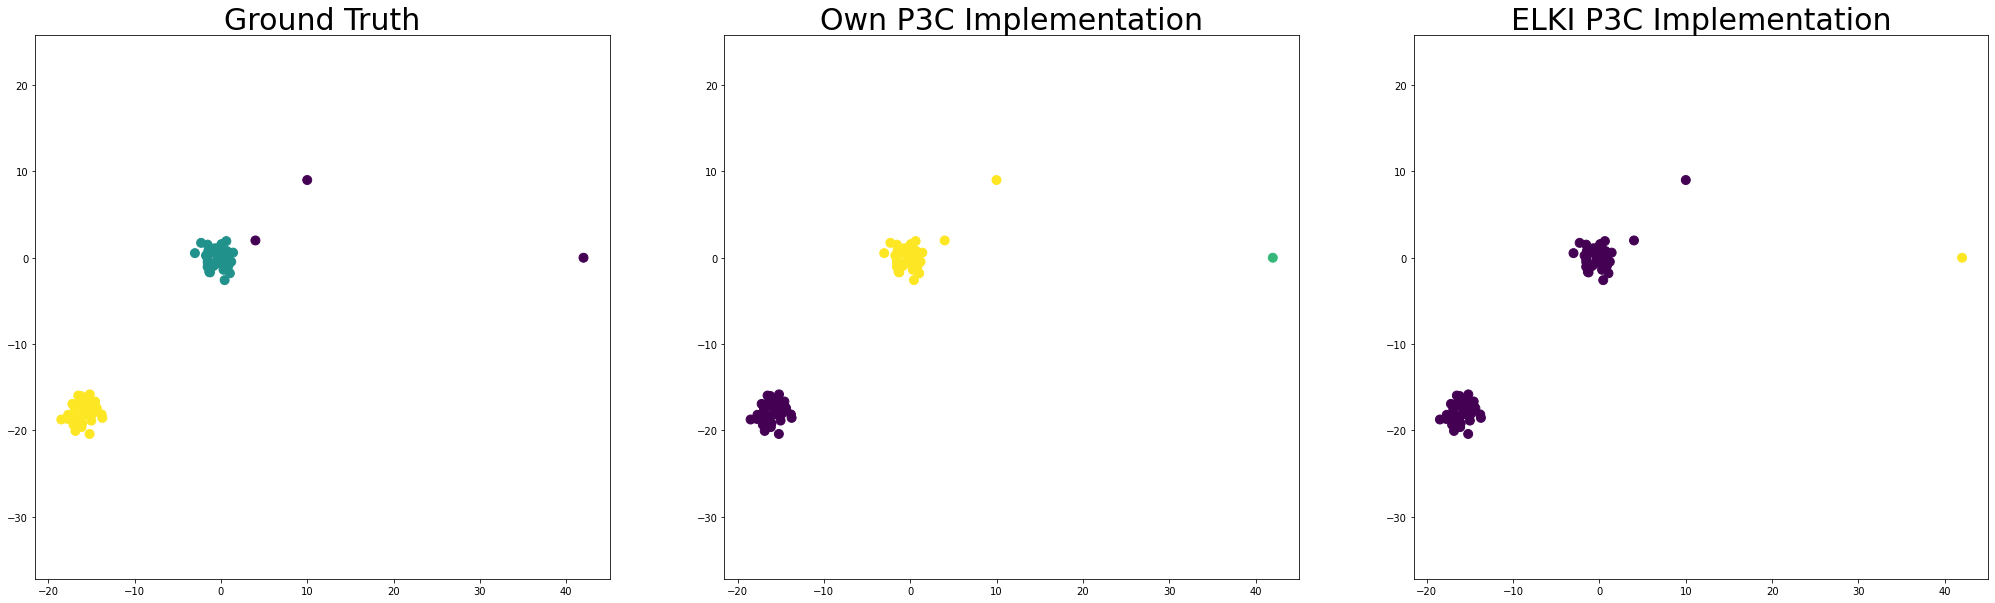

[3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 3 2 3]


In [2]:
### Create synthetic test data outliers
N = 2
samples = 40
cov = np.eye(N)
data1 = np.random.multivariate_normal([0,0], cov, samples)
outliers = np.array([[10,9],[42,0],[4,2]])
labels1 = np.zeros(samples)
labels_out = np.full((3), -1)

data2 = np.random.multivariate_normal([-16,-18], cov, samples)
data2 = np.append(data2, outliers, axis=0)
syn_data = np.append(data1, data2, axis=0)
labels2 = np.ones(samples)

labels_= np.append(labels1,labels2, axis=0)
syn_label = np.append(labels_, labels_out, axis=0)


# Run Algorithm
poisson = 1e-100 #the poisson threshold, the only adjustable parameter of P3C
p3c = P3C(poisson)
p3c.fit_predict(syn_data)
syn_pred_P3C = p3c.labels_
syn_pred_ELKI = run_elki_P3C (syn_data, poisson=poisson)

# Compute NMI scores
print('Outlier detection with alpha=0.001')
print (" NMI of own implementation:", normalized_mutual_info_score (syn_pred_P3C, syn_label))
print (" NMI of ELKI implementation:", normalized_mutual_info_score (syn_pred_ELKI, syn_label))

# Visualize outlier results
fig = plt.figure(figsize=(35, 10))
ax0 = fig.add_subplot(131)
ax0.scatter(syn_data[:,0], syn_data[:,1], c=syn_label, s=80)
ax0.set_title("Ground Truth", fontsize=30)
ax0.axis('equal')
ax1 = fig.add_subplot(132)
ax1.scatter(syn_data[:,0], syn_data[:,1], c=syn_pred_P3C, s=80)
ax1.set_title("Own P3C Implementation", fontsize=30)
ax1.axis('equal')
ax2 = fig.add_subplot(133)
ax2.scatter(syn_data[:,0], syn_data[:,1], c=syn_pred_ELKI, s=80)
ax2.set_title("ELKI P3C Implementation", fontsize=30)
ax2.axis('equal')
plt.show ()

# Our labels
print(syn_pred_P3C)

##### Outlier detection with alpha=0.1
<img src='images/outlier_01.png' />

<u>3.5 Relevant Attributes Detection</u>

This part has not been implemented because it is more of a theoretical improvement for corner cases. It is also not implemented in ELKI, because it cannot be easily implemented in the same way as the rest of the algorithm.

<u>Evaluation of the Algorithm</u>

We will now demonstrate the application of our P3C implementation on a synthetic 3D dataset with labels and compare it to the ELKI implementation. Three dimensions have been chosen for visualization purposes, but we will also demonstrate below, that it works with far more dimensions! 

In [33]:
syn_data, syn_label = make_blobs(n_samples=500,
                                 n_features=3,
                                 centers=3,
                                 cluster_std=.5,
                                 random_state=123)

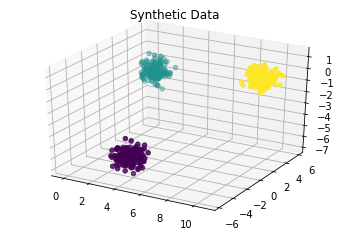

In [34]:
fig = plt.figure()
sub = fig.add_subplot(111, projection='3d')
sub.scatter(syn_data[:,0], syn_data[:,1], syn_data[:,2], c= syn_label)
sub.set_title("Synthetic Data")
plt.show ()

In [35]:
poisson = 1e-100 #the poisson threshold, the only adjustable parameter of P3C
p3c = P3C(poisson)
p3c.fit_predict(syn_data)
syn_pred_P3C = p3c.labels_
syn_pred_ELKI = run_elki_P3C (syn_data, poisson=poisson)

In [36]:
print ("NMI of own implementation:", normalized_mutual_info_score (syn_pred_P3C, syn_label))
print ("NMI of ELKI implementation:", normalized_mutual_info_score (syn_pred_ELKI, syn_label))

NMI of own implementation: 0.9889956710513255
NMI of ELKI implementation: 0.8000233264879105


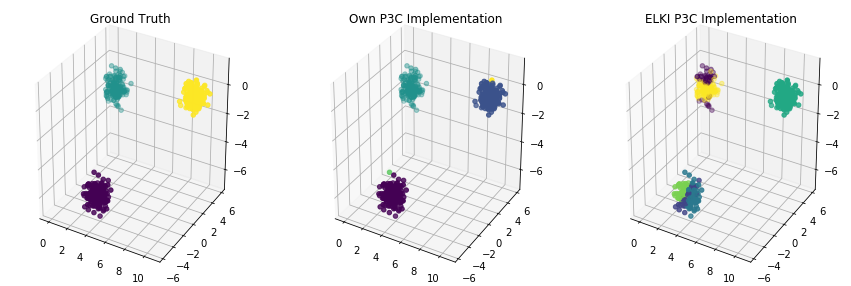

In [37]:
fig = plt.figure(figsize=(15, 5))
ax0 = fig.add_subplot(131, projection='3d')
ax0.scatter(syn_data[:,0], syn_data[:,1], syn_data[:,2], c=syn_label)
ax0.set_title("Ground Truth")
ax1 = fig.add_subplot(132, projection='3d')
ax1.scatter(syn_data[:,0], syn_data[:,1], syn_data[:,2], c=syn_pred_P3C)
ax1.set_title("Own P3C Implementation")
ax2 = fig.add_subplot(133, projection='3d')
ax2.scatter(syn_data[:,0], syn_data[:,1], syn_data[:,2], c=syn_pred_ELKI)
ax2.set_title("ELKI P3C Implementation")
plt.show ()

The results show, that we have found a superior implementation of P3C with respect to finding clusters. We suspect that our implementation of part 3.2 - the finding of cluster cores - is done in a more sophisticated way using an Apriori-like scheme. ELKI's Java implementation of P3C is, however, faster than ours.

As we promised, we can show that those results hold also in higher dimensions - 30 in the following example:

In [38]:
syn_data, syn_label = make_blobs(n_samples=500,
                                 n_features=30,
                                 centers=3,
                                 cluster_std=.5,
                                 random_state=123)

In [39]:
poisson = 1e-100 #the poisson threshold, the only adjustable parameter of P3C
p3c = P3C(poisson)
p3c.fit_predict(syn_data)
syn_pred_P3C = p3c.labels_
syn_pred_ELKI = run_elki_P3C (syn_data, poisson=poisson)

In [40]:
print ("NMI of own implementation:", normalized_mutual_info_score (syn_pred_P3C, syn_label))
print ("NMI of ELKI implementation:", normalized_mutual_info_score (syn_pred_ELKI, syn_label))

NMI of own implementation: 0.7337672693846315
NMI of ELKI implementation: 0.45297839216279917


Finally, it can also be shown, that P3C is extremely unsensitive to the chosen Poisson threshold, as was also claimed in the paper:

In [43]:
syn_data, syn_label = make_blobs(n_samples=100,
                                 n_features=30,
                                 centers=3,
                                 cluster_std=.5,
                                 random_state=123)

In [44]:
poisson_list = [1e-10, 1e-20, 1e-30, 1e-40, 1e-50, 1e-60, 1e-70, 1e-80, 1e-90, 1e-100]
syn_NMI_list = []
for p in poisson_list:
    p3c = P3C(p)
    p3c.fit_predict(syn_data)
    syn_NMI_list.append (normalized_mutual_info_score (p3c.labels_, syn_label))

<BarContainer object of 10 artists>

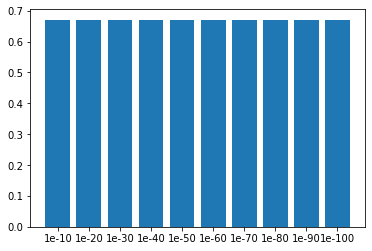

In [30]:
poisson_labels = ['1e-10', '1e-20', '1e-30', '1e-40', '1e-50', '1e-60', '1e-70', '1e-80', '1e-90', '1e-100']
plt.bar (poisson_labels, syn_NMI_list)

Finally, we will have a quick look at a real world dataset, namely the Boston housing dataset that was also used in the paper. It consists of 12 attributes of suburbs in Boston. It has no labels, so we cannot simply calculate an NMI. But, interestingly, we are able to reproduce what was found in the paper: The dataset cluster into 2 large clusters with a lot of smaller cluster and/or outliers:

In [45]:
house_data = np.genfromtxt ('housing.csv')

In [48]:
poisson = 1e-100 #the poisson threshold, the only adjustable parameter of P3C
p3c = P3C(poisson)
p3c.fit_predict(house_data)

In [60]:
cluster = []
for i in range (len (p3c.cluster_centers_)):
    count = 0
    for entry in p3c.labels_:
        if entry == i:
            count += 1
    cluster.append (count)
print ("datapoints in clusters:", cluster)

datapoints in clusters: [249, 84, 23, 28, 33, 9, 7, 5, 3, 12, 14, 7, 3, 3, 5, 4, 3, 5, 3, 2, 4]


#### Task 1 (c)

HCV data set and seed data set have been chosen for this task.
sources:
    
https://archive.ics.uci.edu/ml/datasets/HCV+data
    
https://archive.ics.uci.edu/ml/datasets/seeds

In [ ]:
# Load and preprocess Data
# HCV
dataset_hcv = np.genfromtxt('hcvdat0.csv', delimiter=',')
data_hcv = dataset_hcv[1:,2:]
label_hcv = dataset_hcv[1:,1]

# Seeds
dataset_seeds = np.genfromtxt('seeds_dataset.txt')
data_seeds = dataset_seeds[:,:dataset_seeds.shape[1]-1]
label_seeds = dataset_seeds[:,dataset_seeds.shape[1]-1]

Comparison of our P3C implementation with elki's P3C, dbscan and kmeans on HCV and Seeds dataset.

HCV:

    NMI of P3C on HCV dataset:
    own implementation: 0.1262306702876908
    ELKI implementation: 0.1886190630049598
    ELKI implementation compared to own implementation: 0.3893625154244198
    
    NMI of dbscan on HCV dataset:
    ELKI implementation: 0.0
    
    NMI of kmeans on HCV dataset:
    ELKI implementation: 0.3157645024909989
    ELKI implementation compared to own implementation P3C: 0.1209027291519607
    
Seeds:

    NMI of P3C on Seeds dataset:
    own implementation: 0.521508772947654
    ELKI implementation: 0.0
    ELKI implementation compared to own implementation: 0.0
    
    NMI of dbscan on Seeds dataset:
    ELKI implementation: 0.14764823613022793
    ELKI implementation compared to own implementation P3C: 0.0802847279078177
    
    NMI of kmeans on Seeds dataset:
    ELKI implementation: 0.710063757776045
    ELKI implementation compared to own implementation P3C: 0.4647854261028225

In [ ]:
# HCV
# P3C
poisson = 1e-100
p3c = P3C(poisson)
p3c.fit_predict(data_hcv)
hcv_pred_P3C = p3c.labels_
hcv_pred_ELKI_P3C = run_elki_P3C(data_hcv, poisson=poisson)

print("NMI of P3C on HCV dataset:")
print("own implementation:", normalized_mutual_info_score (hcv_pred_P3C, label_hcv))
print("ELKI implementation:", normalized_mutual_info_score (hcv_pred_ELKI_P3C, label_hcv))
print("ELKI implementation compared to own implementation:", normalized_mutual_info_score (hcv_pred_ELKI_P3C, hcv_pred_P3C))
print("\n")

# SUBCLU
# hcv_pred_ELKI_SUBCLU = run_elki_subclu(data_hcv, epsilon = 0.5, minpts = 3)

# print ("NMI of ELKI implementation of subclu on HCV dataset:", normalized_mutual_info_score (hcv_pred_ELKI_SUBCLU, label_hcv))
# print("\n")

# dbscan
hcv_pred_ELKI_DBSCAN = run_elki_dbscan(data_hcv, epsilon = 0.3, minpts = 3)

print("NMI of dbscan on HCV dataset:")
print ("ELKI implementation:", normalized_mutual_info_score (hcv_pred_ELKI_DBSCAN, label_hcv))
print("\n")


# kmeans
hcv_pred_ELKI_KMEANS = run_elki_kmeans(data_hcv, k = 3)

print("NMI of kmeans on HCV dataset:")
print ("ELKI implementation:", normalized_mutual_info_score (hcv_pred_ELKI_KMEANS, label_hcv))
print("ELKI implementation compared to own implementation P3C:", normalized_mutual_info_score (hcv_pred_ELKI_KMEANS, hcv_pred_P3C))

In [ ]:
# Seeds
# P3C
poisson = 1e-100
p3c = P3C(poisson)
p3c.fit_predict(data_seeds)
seeds_pred_P3C = p3c.labels_
seeds_pred_ELKI_P3C = run_elki_P3C(data_seeds, poisson=poisson)

print("NMI of P3C on Seeds dataset:")
print ("own implementation:", normalized_mutual_info_score (seeds_pred_P3C, label_seeds))
print ("ELKI implementation:", normalized_mutual_info_score (seeds_pred_ELKI_P3C, label_seeds))
print ("ELKI implementation compared to own implementation:", normalized_mutual_info_score (seeds_pred_ELKI_P3C, seeds_pred_P3C))
print("\n")

# SUBCLU
# seeds_pred_ELKI_SUBCLU = run_elki_subclu(data_seeds, epsilon = 0.5, minpts = 3)

# print ("NMI of ELKI implementation of subclu on HCV dataset:", normalized_mutual_info_score (hcv_pred_ELKI_SUBCLU, label_hcv))
# print("\n")

# dbscan
seeds_pred_ELKI_DBSCAN = run_elki_dbscan(data_seeds, epsilon = 0.3, minpts = 3)

print("NMI of dbscan on Seeds dataset:")
print("ELKI implementation:", normalized_mutual_info_score (seeds_pred_ELKI_DBSCAN, label_seeds))
print("ELKI implementation compared to own implementation P3C:", normalized_mutual_info_score (seeds_pred_ELKI_DBSCAN, seeds_pred_P3C))
print("\n")

# kmeans
seeds_pred_ELKI_KMEANS = run_elki_kmeans(data_seeds, k = 3)
print("NMI of kmeans on Seeds dataset:")
print ("ELKI implementation:", normalized_mutual_info_score (seeds_pred_ELKI_KMEANS, label_seeds))
print("ELKI implementation compared to own implementation P3C:", normalized_mutual_info_score (seeds_pred_ELKI_KMEANS, seeds_pred_P3C))

#### Work distribution within the group

Manju Mariam Mathew left the group without contributing any working code parts or experiments. All the other four students contributed different yet similar important parts to the whole project. Workload was high due to the absence of one team member. Below, the main work packages of each of us are listed:

* Robert Brunnsteiner: Class design P3C; P3C parts 3.1 and 3.3 implementation; ELKI scrip; Evaluation of own P3C implementation.
* Mohammad Mahdi Fallah: P3C parts 3.1 and 3.3 implementation and report; Evaluation of P3C's strengths and comparison to other algorithms.
* Akshey Kumar: P3C parts 3.2. and 3.4 implementation; Evaluation of outlier detection.
* Jan-Jonas Schumacher: P3C parts 3.2. and 3.4 implementation and report; Evaluation of outlier detection.

Those are just the main work packages. We always helped and assisted each other and discussed the results with each other!